# BERT Research / Creating BERT classifier

## 1. Load some pre-trained models

Link to BERT's github containing pre-trained models for BERT: https://github.com/google-research/bert

In [1]:
import torch

In [2]:
from pytorch_pretrained_bert import BertTokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
tokenizerM = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [5]:
tokenizerP = BertTokenizer.from_pretrained('bert-base-portuguese-cased')

## 2. Inspect vocabularies

In [6]:
tokenizer.save_vocabulary('TextFiles')

'TextFiles\\vocab.txt'

In [7]:
len(tokenizer.vocab)

30522

In [8]:
tokenizer.vocab.get('brooklyn')

6613

In [9]:
tokenizer.tokenize(u"We're going to Brooklyn on October 27 to visit Microsoft in Delta Airlines flight DE3452.")

['we',
 "'",
 're',
 'going',
 'to',
 'brooklyn',
 'on',
 'october',
 '27',
 'to',
 'visit',
 'microsoft',
 'in',
 'delta',
 'airlines',
 'flight',
 'de',
 '##34',
 '##52',
 '.']

In [10]:
tokenizerM.save_vocabulary('TextFiles')

'TextFiles\\vocab.txt'

In [11]:
len(tokenizerM.vocab)

119547

In [12]:
tokenizerP.save_vocabulary('TextFiles')

'TextFiles\\vocab.txt'

In [13]:
for token in tokenizerP.vocab.keys():
    if token == 'Gonçalo':
        print('O meu nome existe!')
        break
else:
    print('Tough luck...')

O meu nome existe!


In [14]:
tokenizerP.vocab.get('Santos')

2995

## 3. Creating a classifier with Bert

#### Making use of the GPU

In [15]:
import tensorflow as tf

In [16]:
print(tf.test.gpu_device_name())

In [17]:
print(torch.cuda.is_available())
torch.cuda.get_device_name()

True


'GeForce 940MX'

In [18]:
device = torch.device('cuda')

#### Installing the Hugging Face library Transformers

In [19]:
#!pip install transformers

#### Downloading CoLA  dataset
COLA stands for Corpus of Linguistic Acceptability
more details in https://nyu-mll.github.io/CoLA/

In [20]:
#!pip install wget

In [21]:
import wget
import os

print('Donwloading the CoLA dataset...')

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url,'./cola_public_1.1.zip')
else:
    print('File already downloaded')

Donwloading the CoLA dataset...
File already downloaded


In [22]:
# Unzip dataset
import zipfile
if not os.path.exists('./cola_public/'):
    with zipfile.ZipFile('./cola_public_1.1.zip', 'r') as zip_f:
        zip_f.extractall()
else:
    print('File already unzipped')

File already unzipped


#### Accessing the CoLA data set

In [23]:
import pandas as pd
df = pd.read_csv('./cola_public/raw/in_domain_train.tsv', sep='\t', header=None, names=['sentence_source','label','label_notes','sentence'])

In [24]:
df.sample(10)

,sentence_source,label,label_notes,sentence
6923,m_02,1,NaN,Alan made the loaf with strong white flour.
5496,b_73,1,NaN,Hilda is such a scholar as you were speaking o...
5234,kl93,1,NaN,He bought a Honda.
3321,l-93,1,NaN,I herded the cattle.
8049,ad03,0,*,Aphrodite quickly may free the animals
7084,sgww85,0,*,The students and Professor Swansong is meeting...
6123,c_13,0,*,She was kissed him.
6889,m_02,1,NaN,The baby is heavy.
4038,ks08,1,NaN,Joe warned the class that the exam would be di...
4425,ks08,1,NaN,John is running to the car.


In [25]:
# Pass sentences and labels to numpy arrays
sentences = df.sentence.values
labels = df.label.values

#### Tokenization and input formatting

The tokenizer.encode function will perform 3 functions which are necessary for the BERT classifier:
<br>&nbsp;&nbsp;1) split each sentence into tokens
<br>&nbsp;&nbsp;2) add [CLS] and [SEC] tokens to the beginning and end of each sentence respectively
<br>&nbsp;&nbsp;3) map the tokens to their IDs

In [26]:
# import Bert tokenizer from the Hugging Face library transformers, not from Pytorch as in the top of this notebook
from transformers import BertTokenizer as T_BertTokenizer

In [27]:
T_tokenizer = T_BertTokenizer.from_pretrained('bert-base-uncased')

In [28]:
print(f"Original: {sentences[0]}")
print(f"Tokenized: {T_tokenizer.tokenize(sentences[0])}")
print(f"Encoded: {T_tokenizer.encode(sentences[0])}")

Original: Our friends won't buy this analysis, let alone the next one we propose.
Tokenized: ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Encoded: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [29]:
input_ids=[]
for sent in sentences:
    encoded_sent = T_tokenizer.encode(sent,add_special_tokens=True,max_length=64,pad_to_max_length=True)
    input_ids.append(encoded_sent)

In [30]:
# Creating attention masks - they have 1 for each word and 0 for padding
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

#### Creating training and test set

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,labels,random_state=2018,test_size=0.1)

In [33]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks,labels,random_state=2018,test_size=0.1)

In [34]:
# Convert into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Setting up DataLoader from Pytorch to train in batches for better memory use (in this case not needed, so just for future reference)

In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 16

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler, batch_size=batch_size)

#### Training the sequence classification model

In [36]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [37]:
classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           num_labels=2,
                                                           output_attentions=False,
                                                           output_hidden_states=False)

In [38]:
classifier.cuda() # tell pytorch to run this model in GPU

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [39]:
# Creating optimizer and learning rate scheduler
# Optimizer updates the weights:
optimizer = AdamW(classifier.parameters(),
                 lr = 2e-5, 
                 eps= 1e-8)
#Scheduler handles the learning rate decay:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [40]:
#Helper function for calculating accuracy
import numpy as np
def flat_accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat)/(len(labels_flat))


In [41]:
#Helper function for formatting elapsed times
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))


Actual Training

In [42]:
#Set random values to get reproducibility
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [43]:
#Store average loss value for showing in graph later
loss_values=[]

#For each epoch
for epoch_i in range(0,epochs):
    print('')
    print(f'###### Epoch {epoch_i +1 }/{epochs} ########')
    print('Training')
    
    t0 = time.time() # start timer
    total_loss = 0 # reset total loss for each epoch
    
    classifier.train() # put the model in training mode
    
    #For each batch of training data
    #Actual batch training loop
    
    for step, batch in enumerate(train_dataloader):
        
        #Provide progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time()-t0)            
            print(f'   Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}   ')
        
        #Next step, unpack training batch from dataloader
        #Each batch contains 3 tensors: [0] input_ids, [1] attention masks, [2] labels
        #Each tensor gets copied to the GPU with .to(device)
        
        b_input_ids = batch[0].to(device) 
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)        
        
        #Clear the gradients, otherwise per default for RNN gradients are accumulated, which is not desired here
        
        classifier.zero_grad()
        
        #Perform a forward pass, i.e. evaluate model on the training batch
        #More info on model function in: https://huggingface.co/transformers/v2.2.0/model_doc/bert.html
        
        outputs = classifier(b_input_ids,
                       token_type_ids = None,
                       attention_mask = b_input_mask,
                       labels = b_labels) # because we add the labels vector, output will return loss
        
        loss = outputs[0]
        
        total_loss += loss.item() # loss is actually a single value in the tensor
        
        # Perform backward pass to calculate gradients
        loss.backward()
        
        #Gradient clipping for preventing 'exploding gradients'
        torch.nn.utils.clip_grad_norm_(classifier.parameters(),1.0)
        
        #Optimizer makes adjustment to the weights, according to gradients
        optimizer.step()
        
        #Update the learning rate, i.e. apply decay rate
        scheduler.step()
        
    #Average training loss
    avg_train_loss = total_loss / len(train_dataloader)
    
    #Store in list for later plotting
    loss_values.append(avg_train_loss)
    
    print('')
    print(f'   Average training loss: {avg_train_loss}')
    print(f'   Training epoch took: {time.time()-t0}')
          
    print('')
    print('Running validation...')
          
    t0 = time.time()
    
    classifier.eval() #set model to evalutation mode, drop out layers in BERT behave differently
          
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps, nb_eval_examples = 0,0
        
    #Evaluate for each epoch, i.e. run the model as is on the validation set
    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
          
        b_input_ids, b_input_mask, b_labels = batch
          
        with torch.no_grad():
              outputs = classifier(b_input_ids,
                                   token_type_ids = None,
                                   attention_mask = b_input_mask) 
              # because we add no labels vector, output will return logits, i.e. results
        
        logits = outputs[0] # logits are the outputs prior to applying the activation function
                
        #Move logits to CPU
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
          
        #Calculate the accuracy for this batch of test
        tmp_eval_accuracy = flat_accuracy(logits,label_ids)
          
        eval_accuracy += tmp_eval_accuracy
          
        nb_eval_steps += 1
    
    print(f'Accuracy: {eval_accuracy/nb_eval_steps}')
    print(f'Validation time: {time.time()-t0}') 
    
print("------Training complete------")
          


###### Epoch 1/4 ########
Training
   Batch 40 of 481. Elapsed: 0:01:45   
   Batch 80 of 481. Elapsed: 0:03:30   
   Batch 120 of 481. Elapsed: 0:05:14   
   Batch 160 of 481. Elapsed: 0:06:59   
   Batch 200 of 481. Elapsed: 0:08:44   
   Batch 240 of 481. Elapsed: 0:10:28   
   Batch 280 of 481. Elapsed: 0:12:13   
   Batch 320 of 481. Elapsed: 0:13:58   
   Batch 360 of 481. Elapsed: 0:15:42   
   Batch 400 of 481. Elapsed: 0:17:27   
   Batch 440 of 481. Elapsed: 0:19:11   
   Batch 480 of 481. Elapsed: 0:20:56   

   Average training loss: 0.4912922078755194
   Training epoch took: 1258.6191229820251

Running validation...
Accuracy: 0.8032407407407407
Validation time: 31.767547369003296

###### Epoch 2/4 ########
Training
   Batch 40 of 481. Elapsed: 0:01:44   
   Batch 80 of 481. Elapsed: 0:03:29   
   Batch 120 of 481. Elapsed: 0:05:14   
   Batch 160 of 481. Elapsed: 0:06:58   
   Batch 200 of 481. Elapsed: 0:08:43   
   Batch 240 of 481. Elapsed: 0:10:28   
   Batch 280 of 4

#### Plotting average training loss 

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [64]:
sns.set(style='darkgrid',font_scale=1.5)

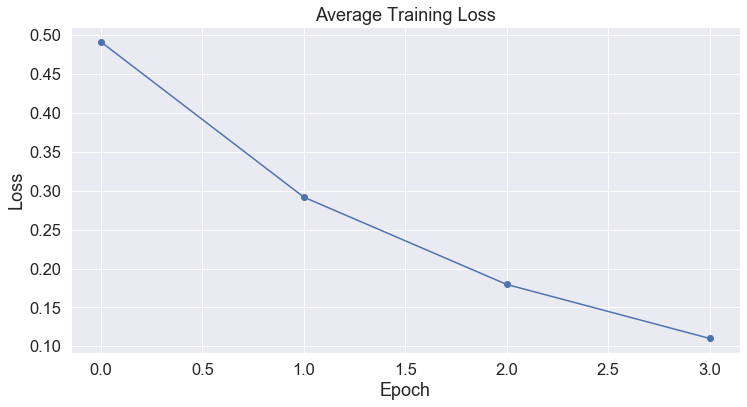

In [67]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(loss_values,'b-o')
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Evaluating the classifier model on the test set provided by the CoLA dataset

In [68]:
# Access data and pass to numpy arrays, same as with training dataset
import pandas as pd
df = pd.read_csv('./cola_public/raw/out_of_domain_dev.tsv', sep='\t', header=None, names=['sentence_source','label','label_notes','sentence'])
sentences = df.sentence.values
labels = df.label.values
print(f"Original: {sentences[0]}")
print(f"Tokenized: {T_tokenizer.tokenize(sentences[0])}")
print(f"Encoded: {T_tokenizer.encode(sentences[0])}")

Original: Somebody just left - guess who.
Tokenized: ['somebody', 'just', 'left', '-', 'guess', 'who', '.']
Encoded: [101, 8307, 2074, 2187, 1011, 3984, 2040, 1012, 102]


In [69]:
#Creating input_ids and attention_masks
input_ids=[]
for sent in sentences:
    encoded_sent = T_tokenizer.encode(sent,add_special_tokens=True,max_length=64,pad_to_max_length=True)
    input_ids.append(encoded_sent)
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [71]:
# Convert into torch tensors
prediction_inputs = torch.tensor(input_ids)
prediction_labels = torch.tensor(labels)
prediction_masks = torch.tensor(attention_masks)

In [72]:
#Create dataloader
batch_size = 16

prediction_data = TensorDataset(prediction_inputs,prediction_masks,prediction_labels)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [74]:
#Prediction on dataset

print('')
print(f'Predicting labels for {len(prediction_inputs)} test sentences')
          
t0 = time.time()
    
classifier.eval() #set model to evalutation mode, drop out layers in BERT behave differently
          
predictions, true_labels = [],[]
        
#Predict
for batch in prediction_dataloader:
    
    batch = tuple(t.to(device) for t in batch)
          
    b_input_ids, b_input_mask, b_labels = batch
          
    with torch.no_grad():
        
        outputs = classifier(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask) 
          # because we add no labels vector, output will return logits, i.e. results
        
    logits = outputs[0] # logits are the outputs prior to applying the activation function
                
    #Move logits to CPU
        
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
          
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
        
    print(f'Prediction time: {format_time(time.time()-t0)}') 
    
print("------Prediction complete------")


Predicting labels for 516 test sentences
Prediction time: 0:00:04
Prediction time: 0:00:05
Prediction time: 0:00:06
Prediction time: 0:00:07
Prediction time: 0:00:08
Prediction time: 0:00:09
Prediction time: 0:00:10
Prediction time: 0:00:11
Prediction time: 0:00:12
Prediction time: 0:00:13
Prediction time: 0:00:14
Prediction time: 0:00:15
Prediction time: 0:00:16
Prediction time: 0:00:17
Prediction time: 0:00:18
Prediction time: 0:00:19
Prediction time: 0:00:20
Prediction time: 0:00:21
Prediction time: 0:00:22
Prediction time: 0:00:23
Prediction time: 0:00:24
Prediction time: 0:00:25
Prediction time: 0:00:26
Prediction time: 0:00:27
Prediction time: 0:00:28
Prediction time: 0:00:29
Prediction time: 0:00:30
Prediction time: 0:00:31
Prediction time: 0:00:32
Prediction time: 0:00:33
Prediction time: 0:00:34
Prediction time: 0:00:35
Prediction time: 0:00:36
------Prediction complete------


In [75]:
from sklearn import metrics

In [91]:
print(f'Positive samples: {df.label.sum()} of {len(df.label)} ({df.label.sum()/len(df.label)})')

Positive samples: 354 of 516 (0.686046511627907)


In [93]:
print('Calculating Matthew Corr Coeff for each batch...')
matthews_set = []

for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i],axis=1).flatten()
    matthews = metrics.matthews_corrcoef(true_labels[i],pred_labels_i)
    matthews_set.append(matthews)

Calculating Matthew Corr Coeff for each batch...


d:\ai_lab\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [95]:
matthews_set

[0.3333333333333333,
 0.4472135954999579,
 0.5606119105813882,
 1.0,
 0.5606119105813882,
 0.8320502943378436,
 0.7333333333333333,
 0.4622501635210242,
 0.4622501635210242,
 0.0,
 0.8563488385776753,
 0.5606119105813882,
 0.38297084310253526,
 0.42857142857142855,
 0.3133397807202561,
 0.2219167619785609,
 0.40451991747794525,
 0.6831300510639732,
 0.4622501635210242,
 0.7745966692414834,
 0.6180700462007377,
 0.3133397807202561,
 0.5897435897435898,
 0.0,
 1.0,
 0.7090909090909091,
 0.5447047794019222,
 0.4472135954999579,
 0.15289415743128767,
 0.7125253031944253,
 -0.09759000729485333,
 0.5897435897435898,
 0.0]

In [99]:
#Combine predictions and labels into single list
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions,axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = metrics.matthews_corrcoef(flat_true_labels, flat_predictions)

In [103]:
print('MCC: %.3f' %mcc)

MCC: 0.519
